# Visualization of Running Data

**Author : Srini Rajagopalan**

I have always been interested in tracking my training data to observe trends, and poosibly identify correlations. Additionally, I have been looking for an interesting project to further my Python skills using Jupyter notebooks.I have created this page to address both my interests.  

I have collected data using on my GPS watch, **Sunnto Ambit 2S** with heart rate monitor

<img src="Suunto_ambit_2s.png" style="width: 250px;float : left">

### I. Parsing Data

The raw data is obtained from www.movescount.com as log files in  [.FIT](https://wiki.openstreetmap.org/wiki/FIT) format.
The FIT files have data organized into various "messages". The messages are parsed using [fitparse library](https://pypi.org/project/fitparse/1.0.0/).The fitparse module reads the messages into objects.The message objects include the following :
- session : This session contains overall summary statistics 
    - Total workout time
    - Calories burnt
    - Total distance 
    - Total number of laps
- record : This message contains timeseries data 
    - Heart rate
    - Distance
    - Speed
    - Altitude
- lap : This message contains lap statistics for every lap
    - Lap duration
    - Lap distance   
    
The dictionaries from these objects are extracted into [pandas](https://pandas.pydata.org/) dataframes for easy handling

In [25]:
# Import data into list of dataframes

import fitparse
from fitparse import FitFile
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import os

def message_to_dict(file,message):
    data_dict = []
    for data in file.get_messages(message):
        # Go through all the data entries
        data_dict.append(data.get_values())
    return data_dict

def get_all_fit_data(datafile):    
    
    # Get all data messages that are of type record into a list of dictionaries 
    session_dicts = message_to_dict(datafile,'session')
    record_dicts = message_to_dict(datafile,'record')
    lap_dicts = message_to_dict(datafile,'lap')    
    
    # Convert list of dictionaires to panda dataframe
    record_data = pd.DataFrame(record_dicts)
    session_data = pd.DataFrame(session_dicts)
    lap_data = pd.DataFrame(lap_dicts)
    
    # Calculate elapsed time & add to data frame
    elapsed_time = []
    for time in record_data.timestamp:
        elapsed_time.append(datetime.timestamp(time))    
    elapsed_time = [(x - elapsed_time[0])/60 for x in elapsed_time]
    record_data['elapsedtime'] = elapsed_time
    
    return record_data,session_data,lap_data

path = r'C:\Users\varad\Downloads\c222f50e-c717-4ed8-ab56-40e636e5e163\Moves'
files =[
    'Move_2020_04_05_09_55_50_Running.fit',
    'Move_2020_04_07_09_09_34_Running.fit',
    'Move_2020_04_09_09_26_59_Running.fit',
    'Move_2020_04_10_12_17_38_Running.fit',
    'Move_2020_04_11_11_20_03_Running.fit',
    'Move_2020_04_15_09_32_49_Running.fit',
    'Move_2020_04_17_08_52_44_Running.fit',
    'Move_2020_04_19_19_31_58_Running.fit',
    'Move_2020_04_21_09_25_08_Running.fit',
    'Move_2020_04_23_09_25_53_Running.fit',
    'Move_2020_04_26_18_42_00_Running.fit',
    'Move_2020_04_28_20_01_20_Running.fit',
    'Move_2020_05_15_17_10_49_Running.fit',
    'Move_2020_05_17_18_18_36_Running.fit'
]

data=[]
record_data=[]
session_data=[]
lap_data=[]

for filename in files:
    fitfile = FitFile(os.path.join(path, filename))
    [r_data,s_data,l_data] =get_all_fit_data(fitfile)
    record_data.append(r_data)
    session_data.append(s_data)
    lap_data.append(l_data)

### II. Time series Analysis

The time-series analysis is to identify the variation/ consistency between runs.

#### i. Heart rate

The plot below shows the heart rate variation through the duraton of the workout. I try to keep my heart rate beween 150 bpm and 185 bpm. 

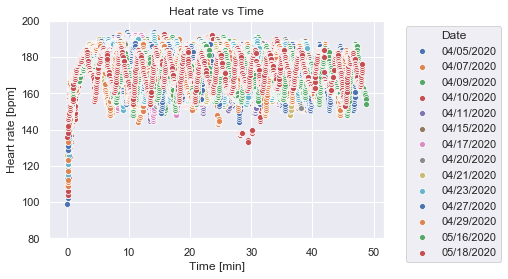

In [27]:
import matplotlib.pyplot as plt
# Plot Time vs heart rate during each workout
sns.set(style="darkgrid")
for record in record_data :
    sns.scatterplot(record.elapsedtime, record.heart_rate)
hr_times =[str((x['timestamp'].dt.strftime('%m/%d/%Y'))[0]) for x in session_data]
plt.xlabel("Time [min]")
plt.ylabel("Heart rate [bpm]")
plt.title('Heat rate vs Time')
plt.ylim([80,200])
plt.legend(hr_times,bbox_to_anchor=(1.05, 1),title='Date');

#### ii. Speed

The plot below shows the variation in running speed through the duration of workout. The speed varies based on my heart-rate control.

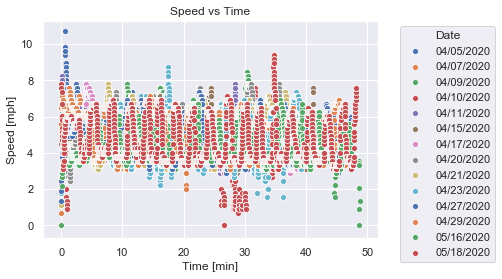

In [28]:
# Plot Time vs Speed during each workout
sns.set(style="darkgrid")
for record in record_data :
    sns.scatterplot(record.elapsedtime,record.enhanced_speed*0.62*3.6)
hr_times =[str((x['timestamp'].dt.strftime('%m/%d/%Y'))[0]) for x in session_data]
plt.xlabel("Time [min]")
plt.ylabel("Speed [mph]")
plt.title('Speed vs Time')
plt.legend(hr_times,bbox_to_anchor=(1.05, 1),title='Date');

#### iii. Distance

The plot below shows the distance vs time through the workout. the slope of curves is the estimate of average speed.

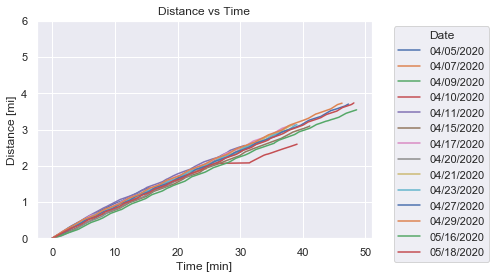

In [29]:
# Plot Time vs distance during the run
sns.set(style="darkgrid")
for record in record_data :
    sns.lineplot(record.elapsedtime, 0.00062*record.distance)
hr_times =[str((x['timestamp'].dt.strftime('%m/%d/%Y'))[0]) for x in session_data]
plt.xlabel("Time [min]")
plt.ylabel("Distance [mi]")
plt.title('Distance vs Time')
plt.ylim([0,6])
plt.legend(hr_times,bbox_to_anchor=(1.05, 1),title='Date');

### III. Run  Average Comparisons

The section visualzes the various average parameters from the different runs to observe trends

#### i. Heart Rate Zones

The stacked bar plot is a multi-dimesional plot that shows the split of the run duration in differnt heart reate zones in each run ,and its comparison to the different runs.

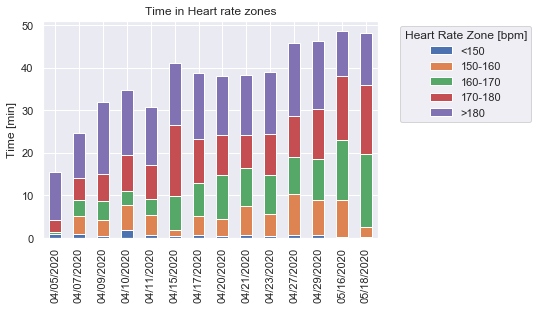

In [30]:
def hr_zones(data,l1,l2):
    # Count time in specified HR zone
    count=0;
    for x in data:
        if x <l2 and x>=l1:
            count=count+1      
    return count

def hr_time_array(data):
    # Build list of times in HR zones
    durs =np.array([hr_zones(data.heart_rate,80,150)/60,
               hr_zones(data.heart_rate,150,160)/60,
               hr_zones(data.heart_rate,160,170)/60,
               hr_zones(data.heart_rate,170,180)/60,
               hr_zones(data.heart_rate,180,200)/60])
    return durs

# HR zone splits for each workout
hr_times =[]
for data in record_data:
    hr_times.append(hr_time_array(data))
hr_times =pd.DataFrame(hr_times)
hr_times.columns = ['<150','150-160','160-170','170-180','>180']
hr_times['Date'] = [str((x['timestamp'].dt.strftime('%m/%d/%Y'))[0]) for x in session_data]

# Plot stacked column of time in each hearrate zone
sns.set(style="darkgrid")
hr_times.plot.bar(stacked=True)
plt.xticks(ticks=range(0,len(session_data)), labels=hr_times.Date)
plt.title('Time in Heart rate zones')
plt.ylabel('Time [min]')
plt.legend(bbox_to_anchor=(1.05, 1),title='Heart Rate Zone [bpm]');

#### ii. Total distance of the run

The chart makes a simple trend of distance run with time.The marker size varies by the average pace to provide context to the run, i.e, if the pace is increasing or decreasing with varying distances

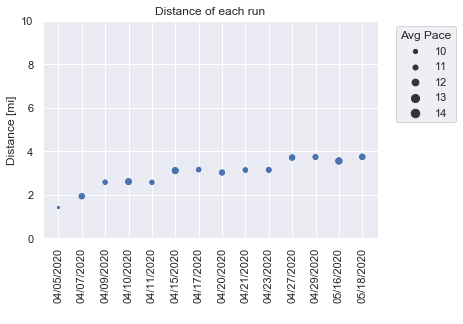

In [31]:
# Calculate average heart rate and average spped, and distance in each run
mean_hr=[]
avg_speed=[]
run_dist=[]
avg_pace=[]
for record in record_data :
    mean_hr.append(np.mean(record.heart_rate))
    avg_speed.append(np.mean(3.6*0.62*record.enhanced_speed))
avg_pace = 60/np.array(avg_speed)
for session in session_data:
    run_dist.append(0.00062*session.total_distance)

# Plot Distance on each run
sns.set(style="darkgrid")
sns.scatterplot(hr_times['Date'],run_dist,size=avg_pace)
plt.ylim([0,10])
plt.xticks(rotation='vertical')
plt.ylabel('Distance [mi]')
plt.xlabel(' ')
plt.title('Distance of each run')
plt.legend(bbox_to_anchor=(1.25, 1),title='Avg Pace');

#### iii. Total Calories

The chart summarizes the total calories burnt in each run. The marker size is varied with distacne of the run to provide context to the calories,i.e., is the increase in calories correspond to distance or not.

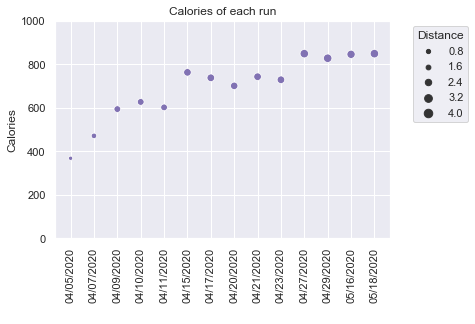

In [32]:
# Extract calories over each run into a list
cal_vec=[]
dist_vec=[]
for session in session_data:
    cal_vec.append(session.total_calories)
    dist_vec.append(session.total_distance[0]*0.00062)
sns.set(style="darkgrid")
sns.scatterplot(hr_times['Date'],cal_vec,color='m',size=dist_vec)
plt.ylabel("Calories")
plt.ylim([0,1000])
plt.xticks(rotation='vertical')
plt.xlabel(' ')
plt.title('Calories of each run')
plt.legend(bbox_to_anchor=(1.25, 1),title='Distance');

#### iv. Speed

The chart plots the varaition of speed of the runs. THe marker size is varied by Avg HR to provide additional insight to the trend.

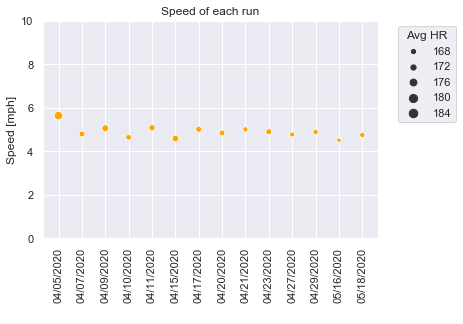

In [33]:
# Plot Speed on each run
sns.set(style="darkgrid")
sns.scatterplot(hr_times['Date'],avg_speed,size=mean_hr,color='orange')
plt.ylim([0,10])
plt.xticks(rotation='vertical')
plt.ylabel('Speed [mph]')
plt.xlabel(' ')
plt.title('Speed of each run')
plt.legend(bbox_to_anchor=(1.25, 1),title='Avg HR');

#### v. Pace
The chart plots the varaition of pace of the runs. THe marker size is varied by Avg HR to provide additional insight to the trend.

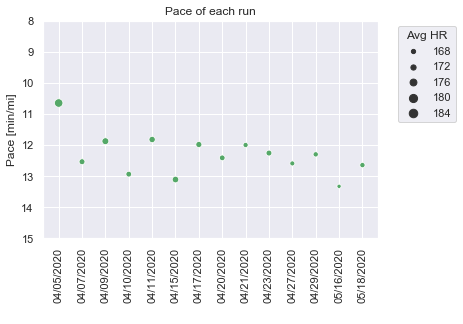

In [34]:
# Plot Pace on each run
sns.set(style="darkgrid")
sns.scatterplot(hr_times['Date'],avg_pace,size=mean_hr,color='g')
plt.ylim([15,8])
plt.xticks(rotation='vertical')
plt.ylabel('Pace [min/mi]')
plt.xlabel(' ')
plt.title('Pace of each run')
plt.legend(bbox_to_anchor=(1.25, 1),title='Avg HR');

### III. Lap  Average Comparisons

The section visualzes the various average parameters from the different laps across the runs to observe trends. Each lap is usually a comparable distance of  ~0.6mi which corrsponds to 1 lap around the Tom Evatt Park

<img src="Training_loop.png" style="width: 800px;float : left">  

#### i. Pace

The chart tracks the trend in average pace across the laps, with each marker color corresponding to a run

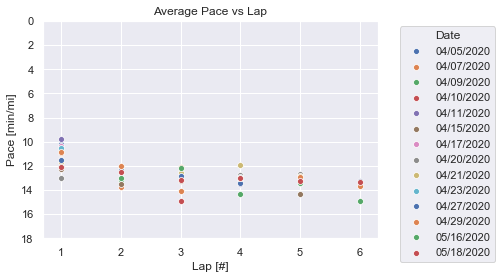

In [35]:
# Plot Average Pace over each lap
sns.set(style="darkgrid")
for lap_session in lap_data:
    lap_session = lap_session[lap_session['total_distance'] > 800]
    sns.scatterplot(lap_session.message_index+1, 60/((lap_session.total_distance/lap_session.total_moving_time)*3.6*0.62))
plt.xlabel("Lap [#]")
plt.ylabel("Pace [min/mi]")
plt.title('Average Pace vs Lap')
plt.legend(hr_times['Date'],bbox_to_anchor=(1.05, 1),title='Date')
plt.ylim([18,0]);

#### ii. Speed
The chart tracks the trend in average speed across the laps, with each marker color corresponding to a run

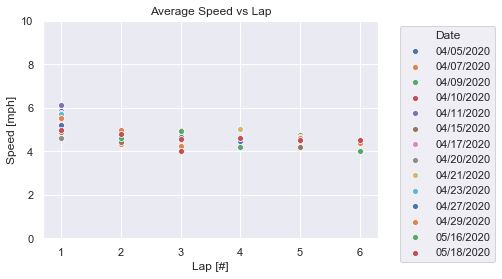

In [36]:
# Plot Average speed over each lap 
sns.set(style="darkgrid")
for lap_session in lap_data:
    lap_session = lap_session[lap_session['total_distance'] > 800]
    sns.scatterplot(lap_session.message_index+1, (lap_session.total_distance/lap_session.total_moving_time)*3.6*0.62)
plt.xlabel("Lap [#]")
plt.ylabel("Speed [mph]")
plt.title('Average Speed vs Lap')
plt.legend(hr_times['Date'],bbox_to_anchor=(1.05, 1),title='Date')
plt.ylim([0,10]);

#### iii. Heart Rate

The chart tracks the average heart rate across the laps, with each marker color corresponding to a run. The average for each lap is computes from averaging timeseries heart rate data between the lap start & end times.

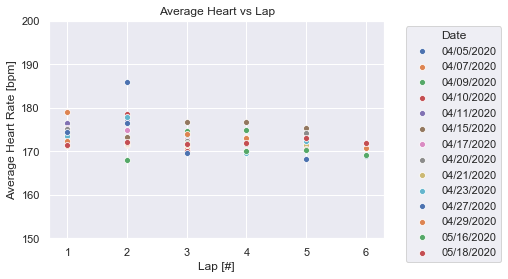

In [37]:
# Calculate average HR over each lap
sns.set(style="darkgrid")
for (record,lap_session) in zip(record_data,lap_data) :
    lap_hr =[];
    for index, row in lap_session.iterrows():
        record['timestamp'] = pd.to_datetime(record['timestamp'])
        time_bool = record['timestamp'].between(row['start_time'], row['timestamp'])
        lap_hr.append(np.mean(record[time_bool].heart_rate))
    lap_session['Avg_HR'] = lap_hr
    
# Plot Average HR over each lap
for lap_session in lap_data :
    lap_session = lap_session[lap_session['total_distance'] > 800]
    sns.scatterplot(lap_session.message_index+1,lap_session.Avg_HR)   
plt.xlabel("Lap [#]")
plt.ylabel("Average Heart Rate [bpm]")
plt.title('Average Heart vs Lap')
plt.legend(hr_times['Date'],bbox_to_anchor=(1.05, 1),title='Date')
plt.ylim([150,200]);